In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# Print data info: nan, unique, dtype
def df_info(df:pd.DataFrame):
  nan_count = df.isna().sum()
  df_info = pd.DataFrame({
    'nan_count':nan_count,
    'nan_percent': np.round(nan_count*100/len(df),4),
    'unique_count': df.nunique(), 
    'dtype': df.dtypes
  })
  return df_info


# Fill nan values of one column with mode of other column
def fill_nan_values_by_column(df, col_name_1, col_name_2, apply_fn):
    # df: dataframe
    # col_name_1: column name of the column to be filled
    # col_name_2: column name of the column to be used to groupby
    # apply_fn: function to apply to each group
    
    col_mode_by_customer_id = df[~df[col_name_1].isna()].groupby([col_name_2])[col_name_1].apply(apply_fn)
    condition = df[col_name_1].isna() & df[col_name_2].isin(col_mode_by_customer_id.index)
    df.loc[condition, col_name_1] = df.loc[condition, col_name_2].map(col_mode_by_customer_id)

# Mark outliers as nan
def mark_outliers_as_nan(df, col_name):
    # df: dataframe
    # col_name: column name of the column to be filled
    # z_threshold: z-score threshold to be considered as outlier
    
    inter_quartile_range = df[col_name].quantile(0.75) - df[col_name].quantile(0.25)
    upper_bound = df[col_name].quantile(0.75) + 1.5 * inter_quartile_range
    lower_bound = df[col_name].quantile(0.25) - 1.5 * inter_quartile_range
    condition = (df[col_name] > upper_bound) | (df[col_name] < lower_bound)
    df.loc[condition, col_name] = np.nan

In [3]:
# load data
pd.set_option('display.max_columns', None)
df = pd.read_csv('../data/uncleaned/data.csv')

/var/folders/sx/c_sxyj753hx_sjy7c76rlnt00000gn/T/ipykernel_22878/1098085858.py:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/uncleaned/data.csv')


In [4]:
df.head(10)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
5,0x1607,CUS_0xd40,June,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",8,4,9.27,4.0,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172331195294,!@9#%8,340.4792117872438,Good
6,0x1608,CUS_0xd40,July,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,8_,11.27,4.0,Good,809.98,22.537593,22 Years and 7 Months,No,49.574949,178.3440674122349,Low_spent_Small_value_payments,244.5653167062043,Good
7,0x1609,CUS_0xd40,August,NaN,23,#F%$D@*&8,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,6,11.27,4.0,Good,809.98,23.933795,NaN,No,49.574949,24.785216509052056,High_spent_Medium_value_payments,358.12416760938714,Standard
8,0x160e,CUS_0x21b1,January,Rick Rothackerj,28_,004-07-5839,_______,34847.84,3037.986667,2,4,6,1,Credit-Builder Loan,3,4,5.42,2.0,Good,605.03,24.464031,26 Years and 7 Months,No,18.816215,104.291825168246,Low_spent_Small_value_payments,470.69062692529184,Standard
9,0x160f,CUS_0x21b1,February,Rick Rothackerj,28,004-07-5839,Teacher,34847.84,3037.986667,2,4,6,1,Credit-Builder Loan,7,1,7.42,2.0,Good,605.03,38.550848,26 Years and 8 Months,No,18.816215,40.39123782853101,High_spent_Large_value_payments,484.5912142650067,Good


In [5]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [6]:
# convert to variables for better readability
# df.columns.tolist()
ID = 'ID'                                              
Customer_ID = 'Customer_ID'                            
Month = 'Month'                                        
Name = 'Name'                                          
Age = 'Age'                                            
SSN = 'SSN'                                            
Occupation = 'Occupation'                              
Annual_Income = 'Annual_Income'                        
Monthly_Inhand_Salary = 'Monthly_Inhand_Salary'        
Num_Bank_Accounts = 'Num_Bank_Accounts'                
Num_Credit_Card = 'Num_Credit_Card'                    
Interest_Rate = 'Interest_Rate'
Num_of_Loan = 'Num_of_Loan'
Type_of_Loan = 'Type_of_Loan'
Delay_from_due_date = 'Delay_from_due_date'
Num_of_Delayed_Payment = 'Num_of_Delayed_Payment'
Changed_Credit_Limit = 'Changed_Credit_Limit'
Num_Credit_Inquiries = 'Num_Credit_Inquiries'
Credit_Mix = 'Credit_Mix'
Outstanding_Debt = 'Outstanding_Debt'
Credit_Utilization_Ratio = 'Credit_Utilization_Ratio'
Credit_History_Age = 'Credit_History_Age'
Payment_of_Min_Amount = 'Payment_of_Min_Amount'
Total_EMI_per_month = 'Total_EMI_per_month'
Amount_invested_monthly = 'Amount_invested_monthly'
Payment_Behaviour = 'Payment_Behaviour'
Monthly_Balance = 'Monthly_Balance'
Credit_Score = 'Credit_Score'

In [7]:
df_info(df)

,nan_count,nan_percent,unique_count,dtype
ID,0,0.000,100000,object
Customer_ID,0,0.000,12500,object
Month,0,0.000,8,object
Name,9985,9.985,10139,object
Age,0,0.000,1788,object
SSN,0,0.000,12501,object
Occupation,0,0.000,16,object
Annual_Income,0,0.000,18940,object
Monthly_Inhand_Salary,15002,15.002,13235,float64
Num_Bank_Accounts,0,0.000,943,int64


In [9]:
df.describe(include='all')

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
count,100000,100000,100000,90015,100000,100000,100000,100000,84998.000000,100000.000000,100000.00000,100000.000000,100000,88592,100000.000000,92998,100000,98035.000000,100000,100000,100000.000000,90970,100000,100000.000000,95521,100000,98800,100000
unique,100000,12500,8,10139,1788,12501,16,18940,NaN,NaN,NaN,NaN,434,6260,NaN,749,4384,NaN,4,13178,NaN,404,3,NaN,91049,7,98792,3
top,0x1602,CUS_0xd40,January,Langep,38,#F%$D@*&8,_______,36585.12,NaN,NaN,NaN,NaN,3,Not Specified,NaN,19,_,NaN,Standard,1360.45,NaN,15 Years and 11 Months,Yes,NaN,__10000__,Low_spent_Small_value_payments,__-333333333333333333333333333__,Standard
freq,1,8,12500,44,2833,5572,7062,16,NaN,NaN,NaN,NaN,14386,1408,NaN,5327,2091,NaN,36479,24,NaN,446,52326,NaN,4305,25513,9,53174
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4194.170850,17.091280,22.47443,72.466040,NaN,NaN,21.068780,NaN,NaN,27.754251,NaN,NaN,32.285173,NaN,NaN,1403.118217,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3183.686167,117.404834,129.05741,466.422621,NaN,NaN,14.860104,NaN,NaN,193.177339,NaN,NaN,5.116875,NaN,NaN,8306.041270,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303.645417,-1.000000,0.00000,1.000000,NaN,NaN,-5.000000,NaN,NaN,0.000000,NaN,NaN,20.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1625.568229,3.000000,4.00000,8.000000,NaN,NaN,10.000000,NaN,NaN,3.000000,NaN,NaN,28.052567,NaN,NaN,30.306660,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093.745000,6.000000,5.00000,13.000000,NaN,NaN,18.000000,NaN,NaN,6.000000,NaN,NaN,32.305784,NaN,NaN,69.249473,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5957.448333,7.000000,7.00000,20.000000,NaN,NaN,28.000000,NaN,NaN,9.000000,NaN,NaN,36.496663,NaN,NaN,161.224249,NaN,NaN,NaN,NaN


In [107]:
# drop useless columns
df.drop([ID, Name, SSN], axis=1, inplace=True)

In [108]:
import re

# fix numeric data column but stored as string
temp_cols = [Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Amount_invested_monthly, Outstanding_Debt , Monthly_Balance]
def convert_to_float(num):
    try : 
        return np.abs(float(num.replace("_","")))
    except :
        return np.nan

for col in temp_cols:
    df[col] = df[col].apply(convert_to_float)

In [109]:
df_info(df)

,nan_count,nan_percent,unique_count,dtype
Customer_ID,0,0.000,12500,object
Month,0,0.000,8,object
Age,0,0.000,1728,float64
Occupation,0,0.000,16,object
Annual_Income,0,0.000,13487,float64
Monthly_Inhand_Salary,15002,15.002,13235,float64
Num_Bank_Accounts,0,0.000,943,int64
Num_Credit_Card,0,0.000,1179,int64
Interest_Rate,0,0.000,1750,int64
Num_of_Loan,0,0.000,413,float64


### Num of credit card

In [110]:
df[Num_Credit_Card].describe()

count    100000.00000
mean         22.47443
std         129.05741
min           0.00000
25%           4.00000
50%           5.00000
75%           7.00000
max        1499.00000
Name: Num_Credit_Card, dtype: float64

In [111]:
df[Num_Credit_Card].replace(0,1,inplace=True)

### Delay from due date

In [112]:
df[Delay_from_due_date].describe()

count    100000.000000
mean         21.068780
std          14.860104
min          -5.000000
25%          10.000000
50%          18.000000
75%          28.000000
max          67.000000
Name: Delay_from_due_date, dtype: float64

In [113]:
df[Delay_from_due_date] = df[Delay_from_due_date].apply(lambda x: np.abs(x))

### Num of bank accounts

In [114]:
df[Num_Bank_Accounts].describe()

count    100000.000000
mean         17.091280
std         117.404834
min          -1.000000
25%           3.000000
50%           6.000000
75%           7.000000
max        1798.000000
Name: Num_Bank_Accounts, dtype: float64

In [115]:
df[Num_Bank_Accounts] = df[Num_Bank_Accounts].apply(lambda x :np.abs(x))

### Credit history age

In [116]:
def History_age(age):
    try : 
        years = int("".join(re.findall('[0-9]',''.join(age.split("and")[0]))))
        month = int("".join(re.findall('[0-9]',''.join(age.split("and")[1]))))
        return years*12 + month
    except :
        return np.nan
df[Credit_History_Age] = df[Credit_History_Age].apply(History_age)

### Payment of min amount

In [117]:
df[Payment_of_Min_Amount].replace("NM","No",inplace=True)

### Payment behavior

In [118]:
df[Payment_Behaviour].value_counts()

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: Payment_Behaviour, dtype: int64

In [119]:
df[Payment_Behaviour].replace("!@9#%8",np.nan, inplace=True)
df[Payment_Behaviour].isna().sum()

7600

### Occupation

In [120]:
df[Occupation].value_counts()

_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

In [121]:
df[Occupation].replace('_______', np.nan, inplace=True)
df[Occupation].isna().sum()

7062

### Credit mix

In [122]:
df[Credit_Mix].value_counts()

Standard    36479
Good        24337
_           20195
Bad         18989
Name: Credit_Mix, dtype: int64

In [123]:
df[Credit_Mix].replace('_', np.nan, inplace=True)
df[Credit_Mix].isna().sum()

20195

In [124]:
df_info(df)

,nan_count,nan_percent,unique_count,dtype
Customer_ID,0,0.000,12500,object
Month,0,0.000,8,object
Age,0,0.000,1728,float64
Occupation,7062,7.062,15,object
Annual_Income,0,0.000,13487,float64
Monthly_Inhand_Salary,15002,15.002,13235,float64
Num_Bank_Accounts,0,0.000,942,int64
Num_Credit_Card,0,0.000,1178,int64
Interest_Rate,0,0.000,1750,int64
Num_of_Loan,0,0.000,413,float64


### Mark outliners with nan

In [125]:
df[Amount_invested_monthly].describe()

count    95521.000000
mean       637.412998
std       2043.319327
min          0.000000
25%         74.534002
50%        135.925682
75%        265.731733
max      10000.000000
Name: Amount_invested_monthly, dtype: float64

In [126]:
num_col_names = df.select_dtypes(include=np.number).columns.tolist()
for col_name in num_col_names:
    mark_outliers_as_nan(df, col_name)

In [127]:
df_info(df)

,nan_count,nan_percent,unique_count,dtype
Customer_ID,0,0.000,12500,object
Month,0,0.000,8,object
Age,2781,2.781,43,float64
Occupation,7062,7.062,15,object
Annual_Income,2783,2.783,12263,float64
Monthly_Inhand_Salary,16685,16.685,12971,float64
Num_Bank_Accounts,1315,1.315,12,float64
Num_Credit_Card,2271,2.271,11,float64
Interest_Rate,2034,2.034,34,float64
Num_of_Loan,4348,4.348,10,float64


In [128]:
# fill nan values grouped by Customer_ID
temp = df_info(df)
for col in df.columns:
  if temp.loc[col,'nan_percent'] == 0:
    continue
  if temp.loc[col,'dtype'] == 'object' or temp.loc[col,'unique_count'] < 500:
    fill_nan_values_by_column(df, col, Customer_ID, lambda x: x.mode()[0])
  else:
    fill_nan_values_by_column(df, col, Customer_ID, lambda x: x.mean())

In [129]:
# fill remaining nan values with mode or median
for col_name in df.columns:
  if temp.loc[col_name,'nan_percent'] == 0:
    continue
  if temp.loc[col_name,'dtype'] == 'object' or temp.loc[col_name,'unique_count'] < 500:
    df[col_name].fillna(df[col_name].mode()[0], inplace=True)
  else:
    df[col_name].fillna(df[col_name].median(), inplace=True)

In [130]:
df_info(df)

,nan_count,nan_percent,unique_count,dtype
Customer_ID,0,0.0,12500,object
Month,0,0.0,8,object
Age,0,0.0,43,float64
Occupation,0,0.0,15,object
Annual_Income,0,0.0,12729,float64
Monthly_Inhand_Salary,0,0.0,16214,float64
Num_Bank_Accounts,0,0.0,12,float64
Num_Credit_Card,0,0.0,11,float64
Interest_Rate,0,0.0,34,float64
Num_of_Loan,0,0.0,10,float64


### Type of loan

In [131]:
# split Type_of_Loan column into one hot columns

condition = ~df[Type_of_Loan].isna()
types_of_loan_list = df.loc[condition,Type_of_Loan].str.replace('and ','').str.split(', ')
types_of_loan = types_of_loan_list.explode().unique().tolist()
df[types_of_loan] = df.loc[condition,Type_of_Loan].str.replace('and ','').str.split(', ').apply(lambda x: pd.Series([1 if i in x else 0 for i in types_of_loan]))

df.drop(Type_of_Loan, axis=1, inplace=True)

In [132]:
df.drop(Customer_ID, axis=1, inplace=True)

In [133]:
df_info(df)

,nan_count,nan_percent,unique_count,dtype
Month,0,0.0,8,object
Age,0,0.0,43,float64
Occupation,0,0.0,15,object
Annual_Income,0,0.0,12729,float64
Monthly_Inhand_Salary,0,0.0,16214,float64
Num_Bank_Accounts,0,0.0,12,float64
Num_Credit_Card,0,0.0,11,float64
Interest_Rate,0,0.0,34,float64
Num_of_Loan,0,0.0,10,float64
Delay_from_due_date,0,0.0,56,float64


## EDA

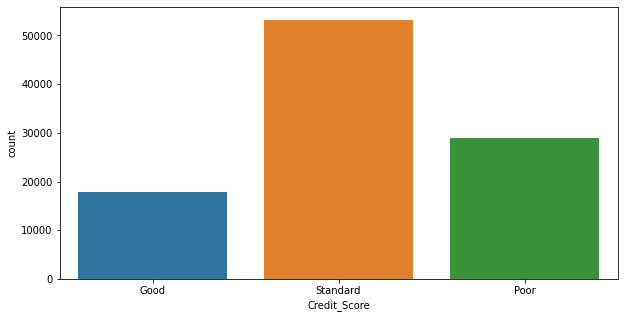

In [134]:
# label distribution
plt.figure(figsize=(10,5))
sns.countplot(df, x=Credit_Score)
plt.show()
# ==> data is imbalanced

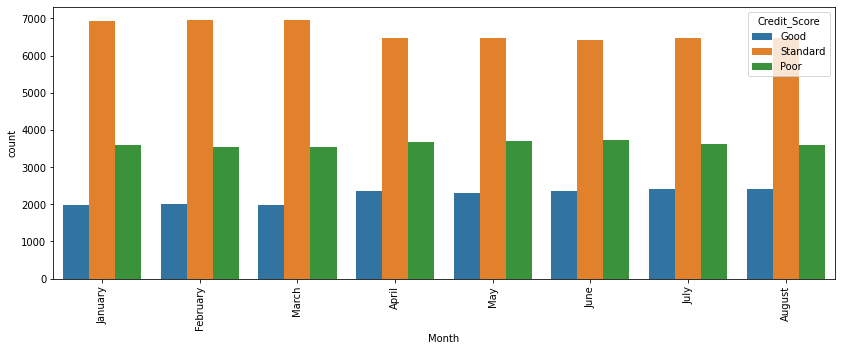

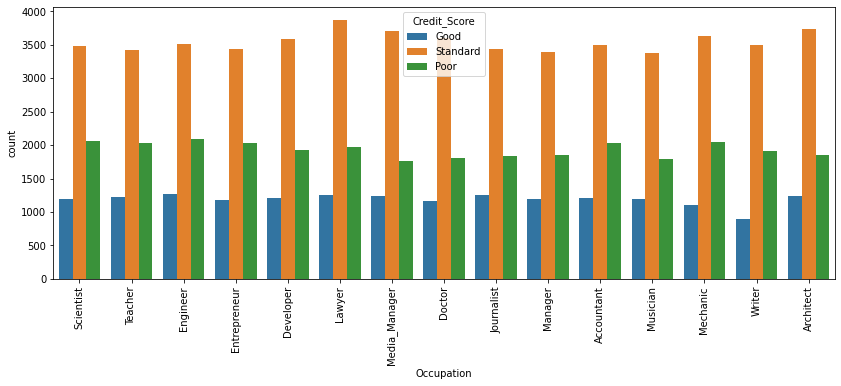

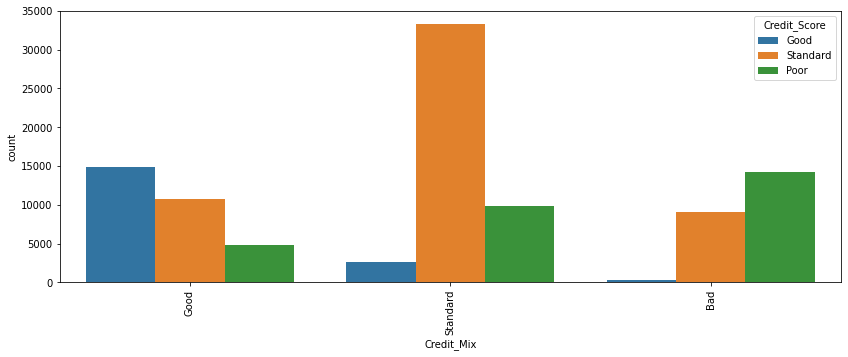

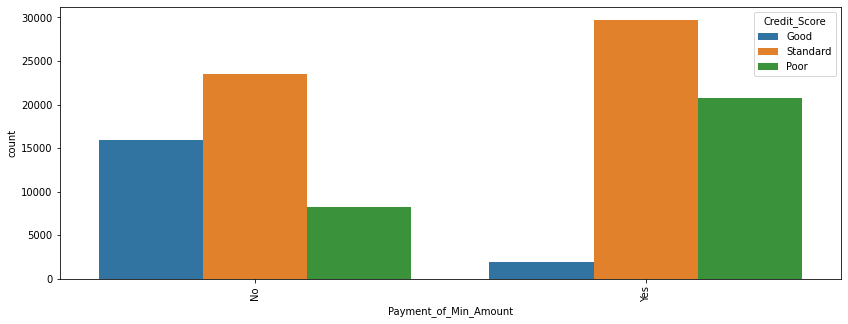

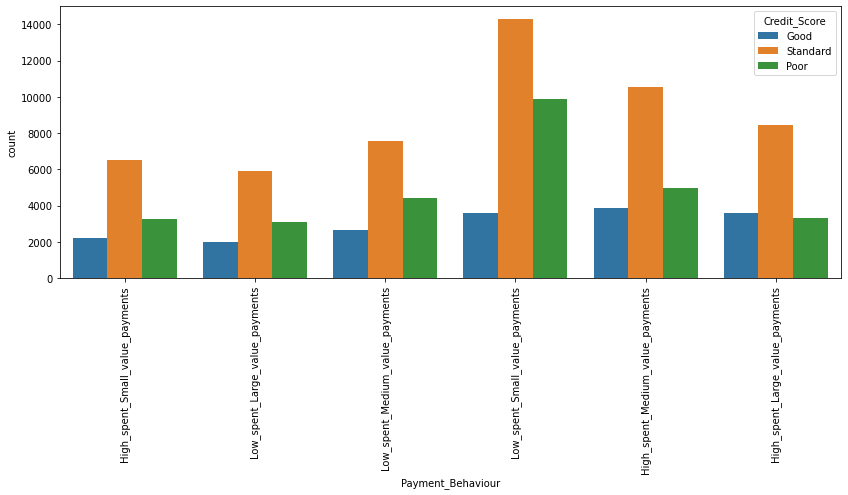

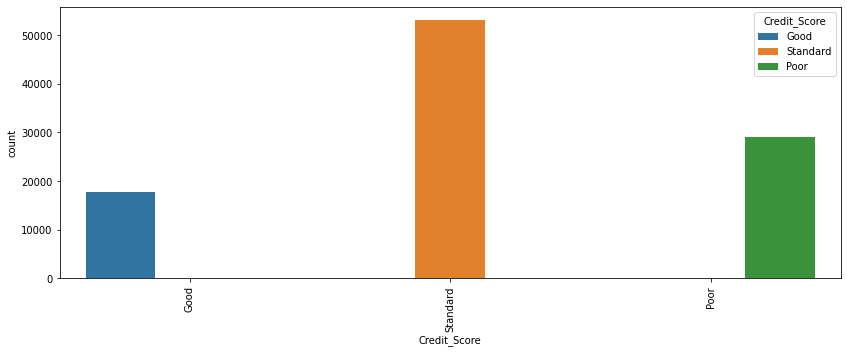

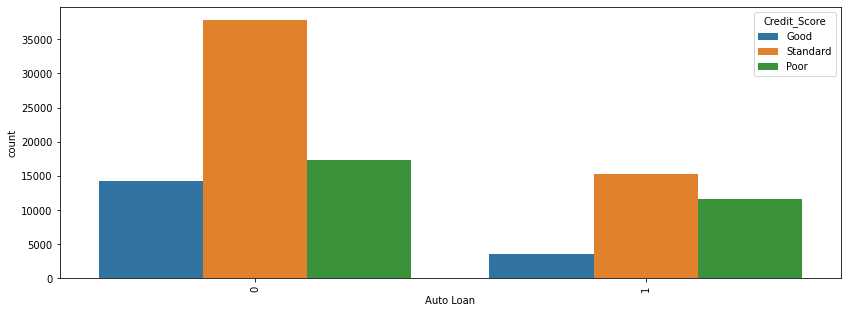

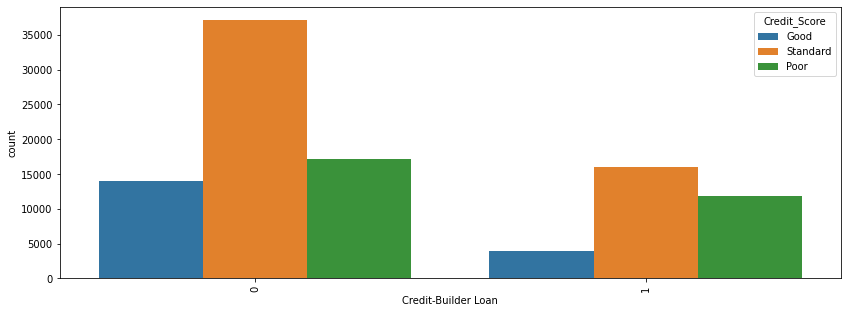

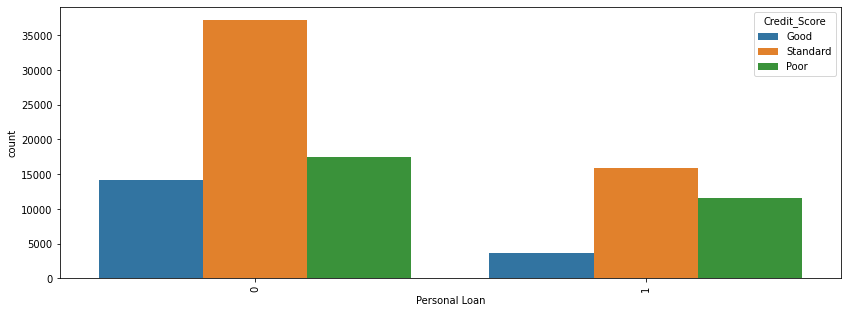

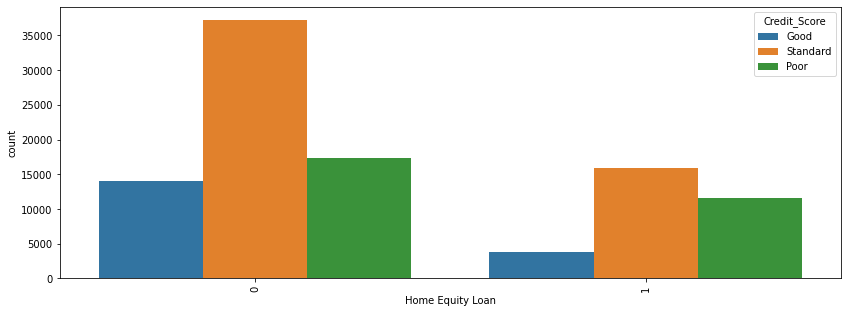

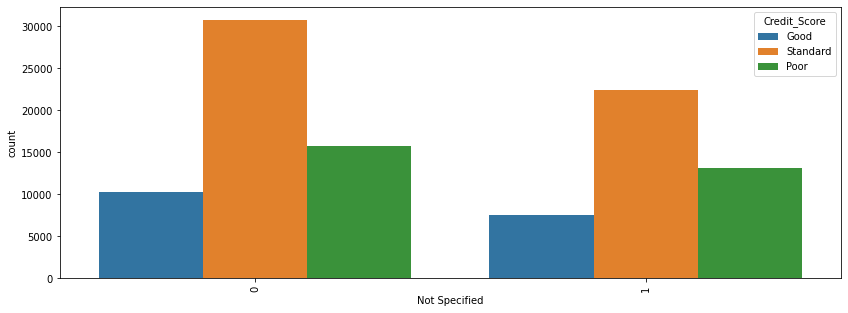

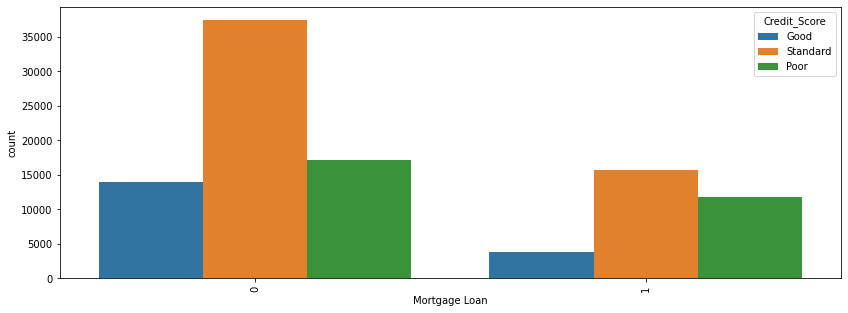

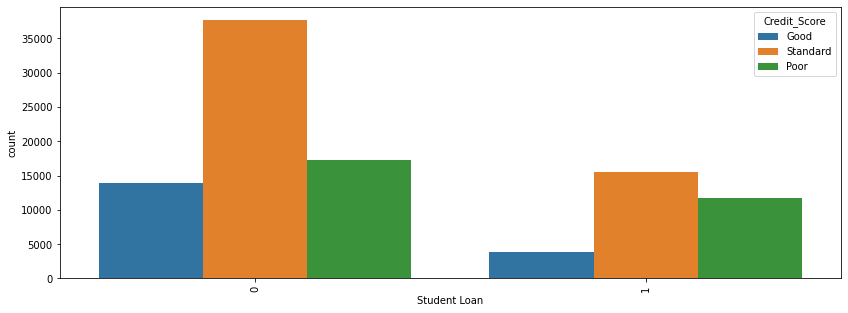

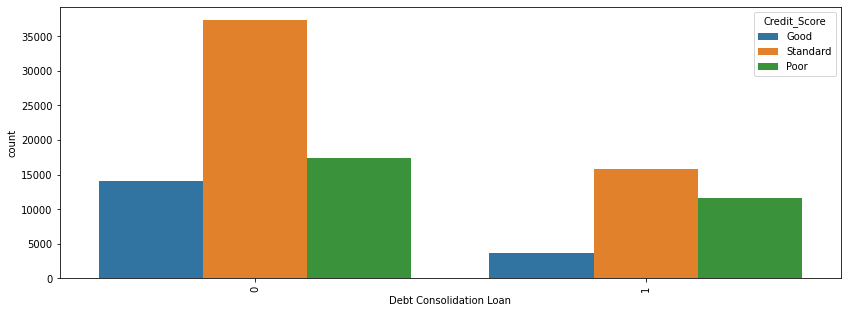

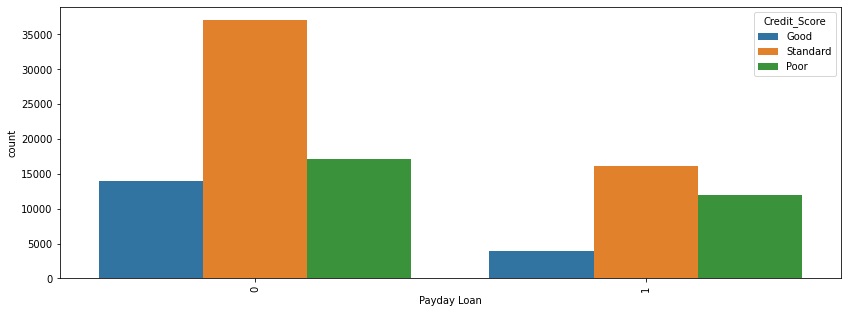

In [135]:
for col in df.columns:
  if df[col].dtype == 'object' or df[col].dtype == 'int64':
    plt.figure(figsize=(14,5))
    sns.countplot(df, x=col, hue=Credit_Score)
    plt.xticks(rotation=90)
    plt.show()

Age


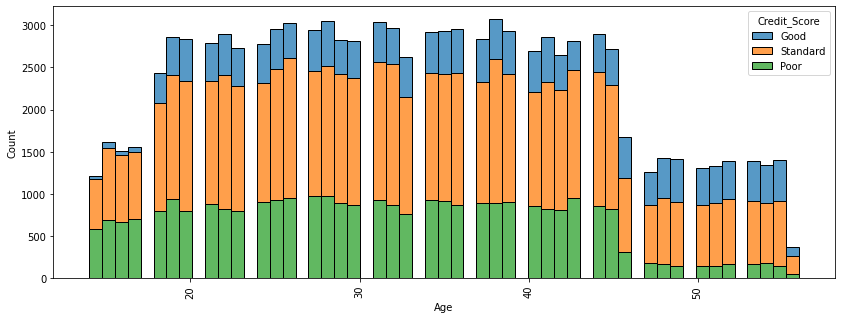

Annual_Income


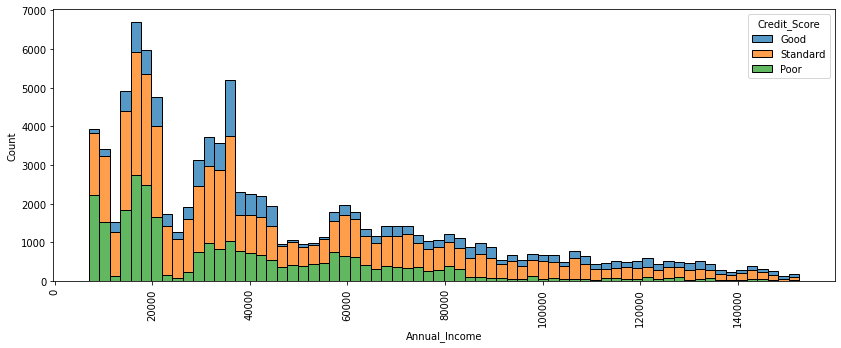

Monthly_Inhand_Salary


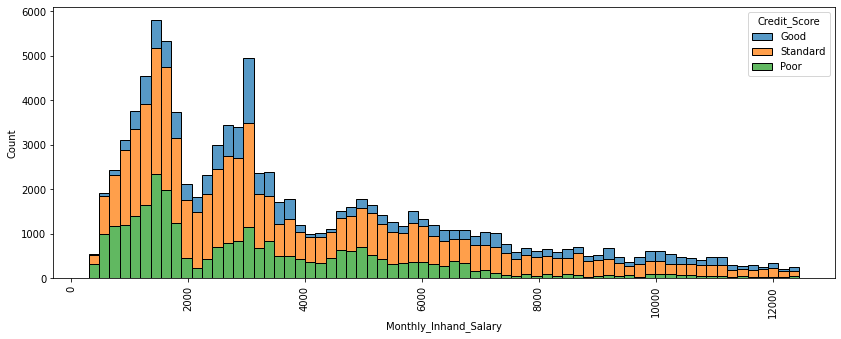

Num_Bank_Accounts


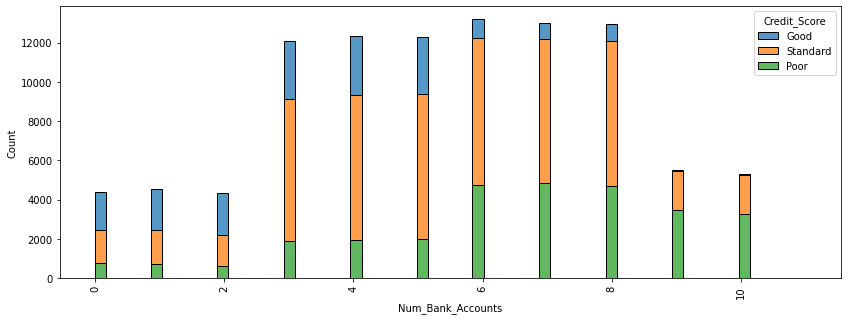

Num_Credit_Card


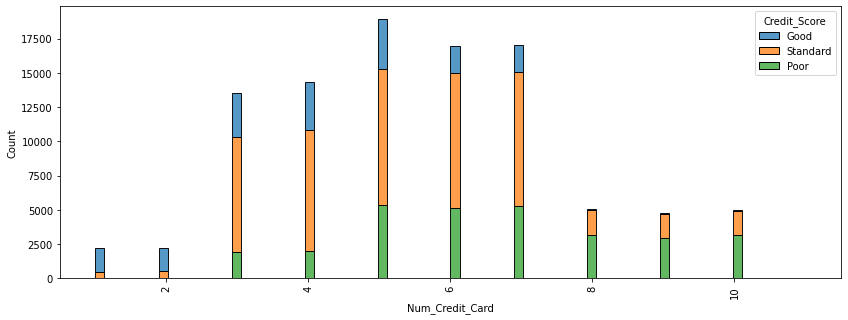

Interest_Rate


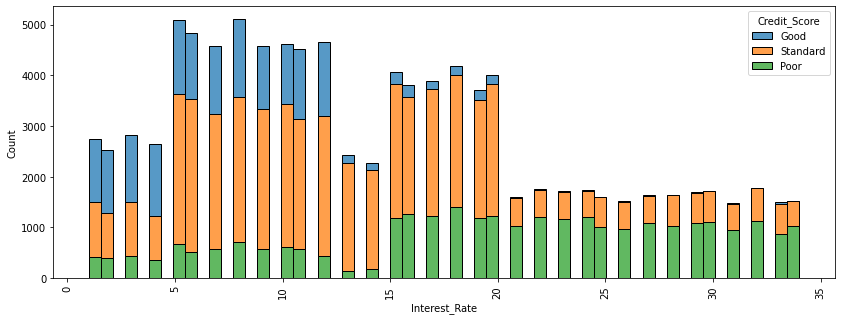

Num_of_Loan


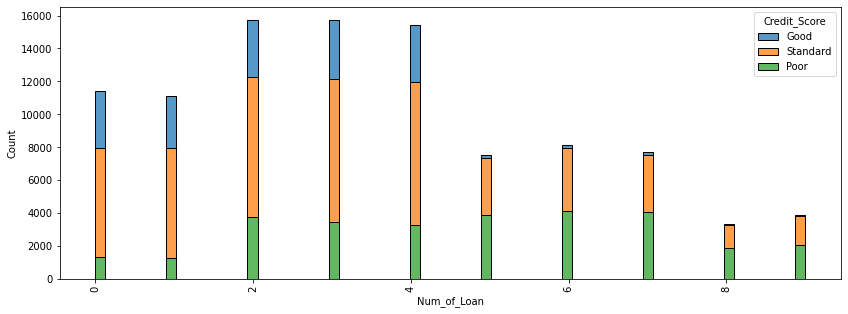

Delay_from_due_date


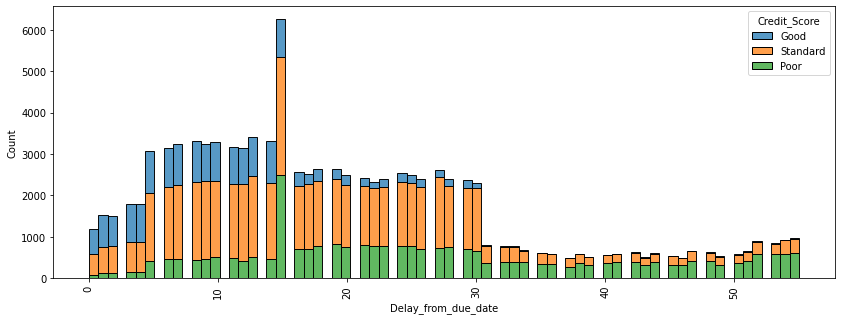

Num_of_Delayed_Payment


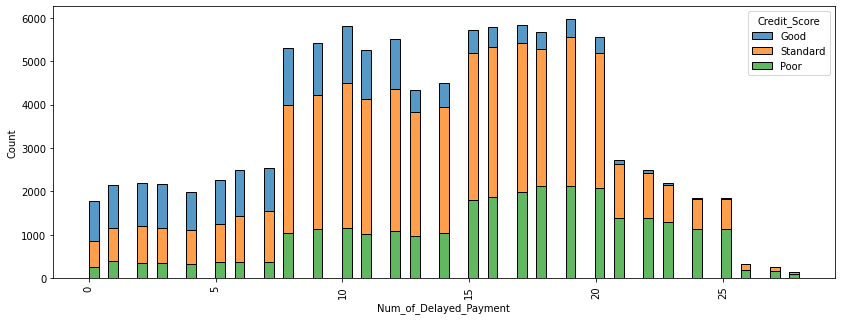

Changed_Credit_Limit


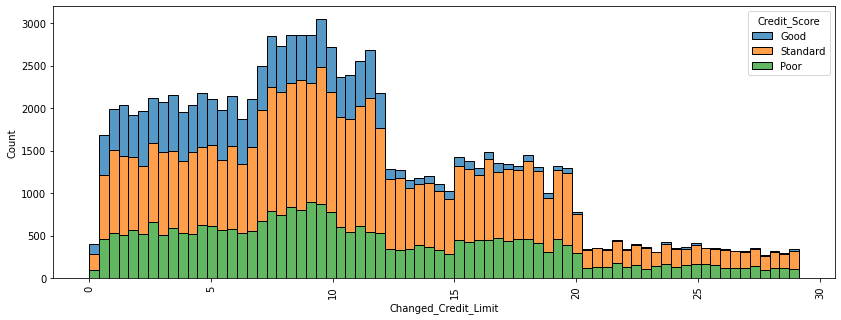

Num_Credit_Inquiries


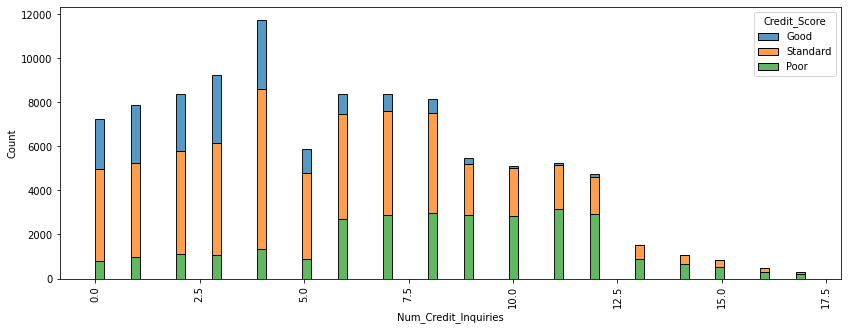

Outstanding_Debt


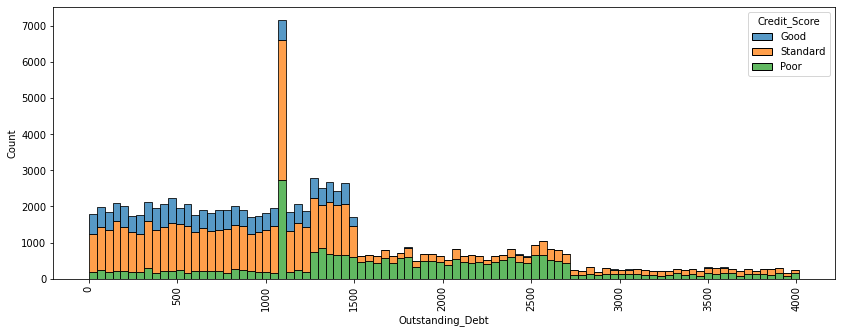

Credit_Utilization_Ratio


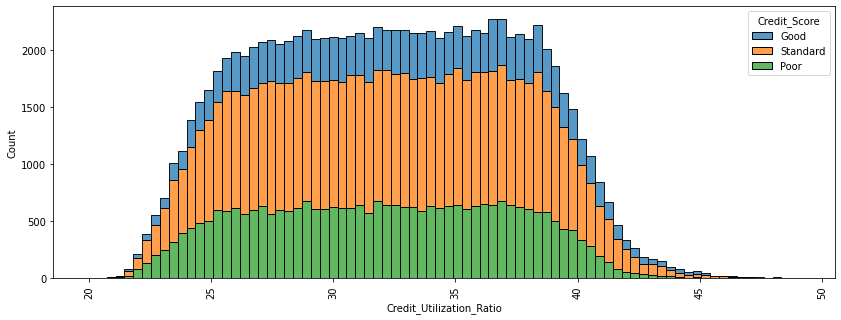

Credit_History_Age


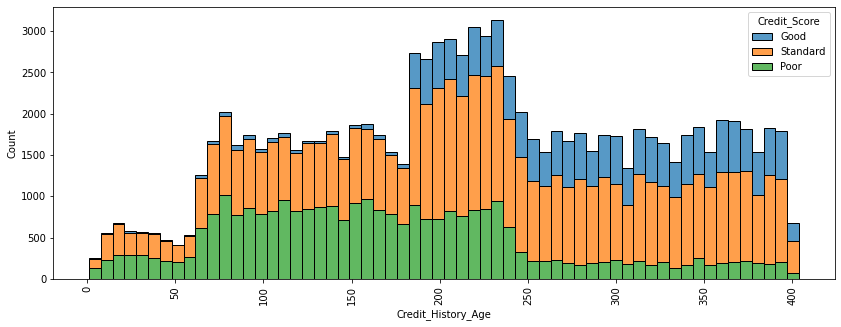

Total_EMI_per_month


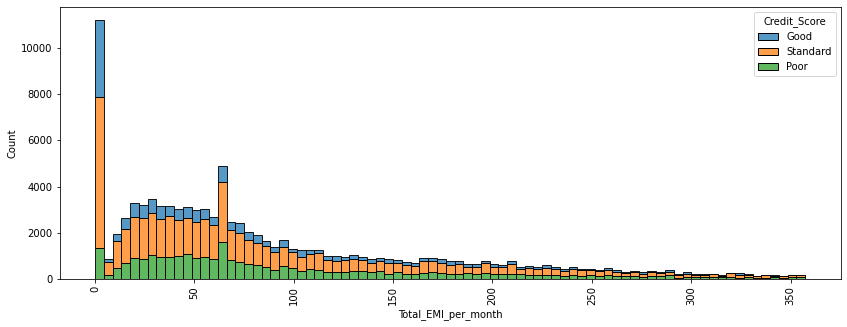

Amount_invested_monthly


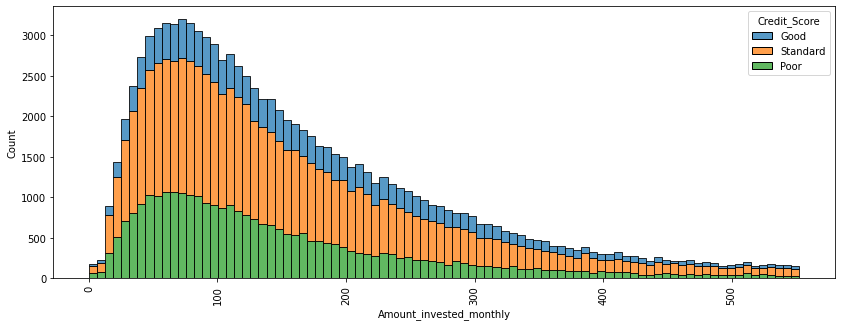

Monthly_Balance


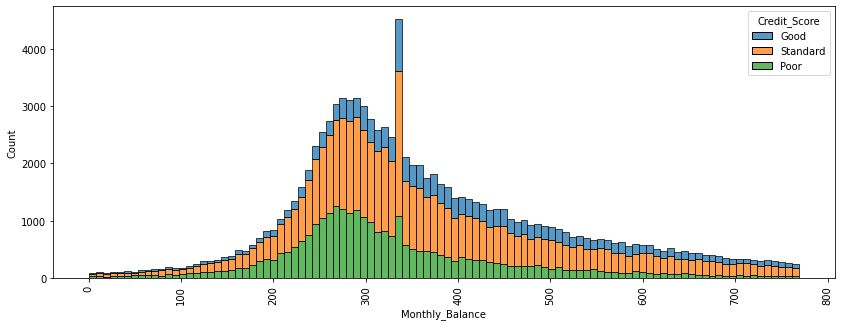

In [139]:
for col in df.columns:
  if df[col].dtype == 'float64':
    print(col)
    plt.figure(figsize=(14,5))
    sns.histplot(df, x=col, hue=Credit_Score, multiple='stack')
    plt.xticks(rotation=90)
    plt.show()
    

In [137]:
# transform categorical columns to one hot columns
onehot_cols = [Month, Occupation, Payment_of_Min_Amount, Payment_Behaviour, Credit_Mix]
df = pd.get_dummies(df, columns=onehot_cols, drop_first=True)

In [138]:
df[Amount_invested_monthly].describe()

count    100000.000000
mean        161.612526
std         113.995164
min           0.000000
25%          74.599540
50%         130.764766
75%         221.233614
max         552.507974
Name: Amount_invested_monthly, dtype: float64

In [41]:
df_info(df)

,nan_count,nan_percent,unique_count,dtype
Age,0,0.0,43,float64
Annual_Income,0,0.0,12729,float64
Monthly_Inhand_Salary,0,0.0,16214,float64
Num_Bank_Accounts,0,0.0,12,float64
Num_Credit_Card,0,0.0,11,float64
Interest_Rate,0,0.0,34,float64
Num_of_Loan,0,0.0,10,float64
Delay_from_due_date,0,0.0,56,float64
Num_of_Delayed_Payment,0,0.0,29,float64
Changed_Credit_Limit,0,0.0,5151,float64


In [52]:
df[Credit_Score] = df[Credit_Score].map({
  'Poor': 0,
  'Standard': 1,
  'Good': 2,
})

# finish cleaning data, save to csv
# df.to_csv('../data/cleaned/data_clean.csv', index=False)

In [4]:
# load cleaned data
df = pd.read_csv('../data/cleaned/data_clean.csv')

# split data into train val and test
target = Credit_Score
training, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df[target])
train, val = train_test_split(training, test_size=0.1667, random_state=42, stratify=training[target])

# save train val and test to csv
# train.to_csv('../data/cleaned/train.csv', index=False)
# val.to_csv('../data/cleaned/val.csv', index=False)
# test.to_csv('../data/cleaned/test.csv', index=False)

In [5]:
train.shape, val.shape, test.shape

((74997, 56), (15003, 56), (10000, 56))

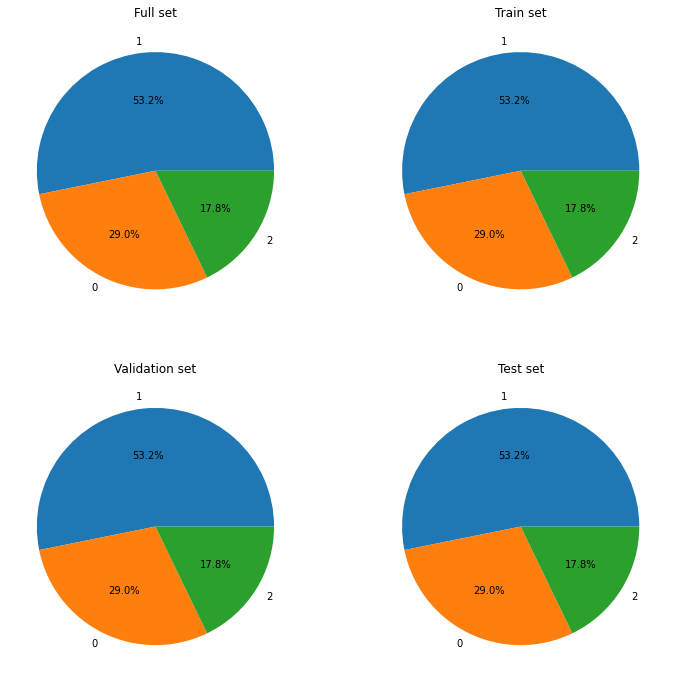

In [6]:
# plot label distribution of train, val and test
y = df[target]
y_train = train[target]
y_val = val[target]
y_test = test[target]

fig, ax = plt.subplots(2,2, figsize=(12,12))
ax[0,0].pie(y.value_counts(), labels=y.value_counts().index, autopct='%1.1f%%')
ax[0,0].set_title('Full set')
ax[0,1].pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%')
ax[0,1].set_title('Train set')
ax[1,0].pie(y_val.value_counts(), labels=y_val.value_counts().index, autopct='%1.1f%%')
ax[1,0].set_title('Validation set')
ax[1,1].pie(y_test.value_counts(), labels=y_test.value_counts().index, autopct='%1.1f%%')
ax[1,1].set_title('Test set')
plt.show()